In [14]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import skimage
import time
import os
import pandas as pd
from skimage import data
from skimage import filters
from skimage.transform import hough_ellipse
from skimage.draw import ellipse_perimeter
from skimage import io, morphology
from skimage.morphology import disk
from skimage.filters.rank import entropy
from sklearn.metrics import confusion_matrix
import random

In [15]:
#Setting filepaths

template_path = 'template.jpg' # path to save generated template for OD localization
train_path = 'IDRID_Segmentation/'
save_path = 'OD_Result/' # path to save OD localization results
if os.path.exists(save_path) is False:
    os.mkdir(save_path)

In [16]:
def getImage(img_num,directory_path):
    path = directory_path
    str_num = str(img_num)
    if (img_num) < 10:
        str_num = '00'+ str_num
    else:
        str_num = '0'+ str_num
    name = 'IDRiD_' + str_num + '.jpg'
    full_path = path + name
    image = cv.imread(full_path, -1)
    return image

 Optic Disc Localization for one image

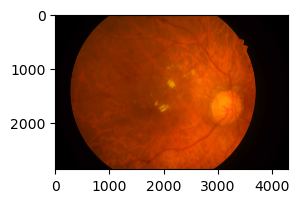

In [17]:
#Retrive Image
img = getImage(29,train_path)
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
plt.figure(figsize=(3,3))
plt.imshow(img,cmap="gray")
plt.show()

Step1 : Resize image 300 x 300 pixels

In [18]:
def imgResize(img):
    img_rs = cv.resize(img,(300,300))
    return img_rs

In [19]:
img_rs = imgResize(img)
print("Before resize :",img.shape)
print("After resize :",img_rs.shape)

Before resize : (2848, 4288, 3)
After resize : (300, 300, 3)


Step 2 :Convert colour image to gray scale image

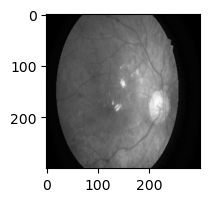

In [20]:
img_grey = cv.cvtColor(img_rs, cv.COLOR_BGR2GRAY)
plt.figure(figsize=(2,2))
plt.imshow(img_grey,cmap = 'gray')
plt.show()

Step 3 : K-means Clustering

In [21]:
def kMeansClustering(img, k, attempts, max_iter, acc):
    
    img_rsp = img.reshape((-1,1))

    img_rsp = img_rsp.astype('float32')


    criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, max_iter, acc)
    _, labels, (centers) = cv.kmeans(img_rsp, k, None, criteria, attempts, cv.KMEANS_RANDOM_CENTERS)
    centers = centers.astype('uint8')

    labels = labels.flatten()
    seg_img = centers[labels.flatten()]
    seg_img = seg_img.reshape(img.shape)
    return seg_img

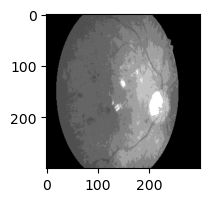

In [22]:
img_k = kMeansClustering(img_grey, 7, 10, 400, 0.99)
plt.figure(figsize=(2,2))
plt.imshow(img_k,cmap = 'gray')
plt.show()

Template creation

True

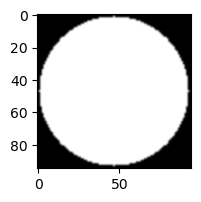

In [23]:
template = np.ones((95,95), dtype="uint8") * 0
template = cv.circle(template, (47,47), 46, 255, -1)
plt.figure(figsize=(2,2))
plt.imshow(template, cmap = 'gray', interpolation = 'bicubic')
cv.imwrite(template_path, template)

Step 4 : Template matching

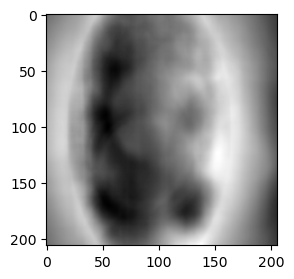

In [24]:
temp = cv.imread(template_path, -1)

metd = cv.TM_CCOEFF_NORMED
temp_mat = cv.matchTemplate(img_k, temp, metd)

min_val, max_val, min_loc, max_loc = cv.minMaxLoc(temp_mat)
x = max_loc[0]+45
y = max_loc[1]+45

plt.figure(figsize = (3,3))
plt.imshow(temp_mat,cmap = 'gray')
plt.show()

Step 5 : Marking optical disc center

198 168


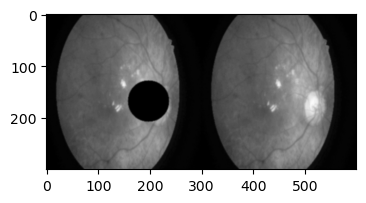

In [25]:
temp_mat = img_grey.copy()
img_mark = cv.circle(temp_mat, (x, y) ,40, 0, -1)
print(x,y)
img_stack = np.hstack([img_mark, img_grey])

plt.figure(figsize=(4,4))
plt.imshow(img_stack, cmap = 'gray', interpolation = 'bicubic')
plt.show()

Accuracy of Dataset - 81 Images 

In [26]:
markUp = pd.read_csv('IDRiD_Training Set_Markups.csv')
markUp.head()

,Image No,X- Coordinate,Y - Coordinate
0,IDRiD_001,2858.0,1805.0
1,IDRiD_002,943.0,1119.0
2,IDRiD_003,779.0,1269.0
3,IDRiD_004,1292.0,1284.0
4,IDRiD_005,1037.0,1198.0


In [27]:
start_time = time.time()
corr_localized = []
incorr_localized = []

for num in range(1,82):
    img = getImage(num,train_path)
    img_rs = imgResize(img)
    img_grey = cv.cvtColor(img_rs, cv.COLOR_BGR2GRAY)
    img_k = kMeansClustering(img_grey, 7, 10, 400, 0.99)
    temp = cv.imread(template_path, -1)
    #TEMPLATE MATCHING
    metd = cv.TM_CCOEFF_NORMED
    temp_mat = cv.matchTemplate(img_k, temp, metd)

    min_val, max_val, min_loc, max_loc = cv.minMaxLoc(temp_mat)
    x = max_loc[0]+45
    y = max_loc[1]+45
    
    temp_mat = img_grey.copy()
    img_mark = cv.circle(temp_mat, (x, y) ,40, 0, -1)
    
    # Saving the marked images to result folder
    if (num<10):
        img_path = save_path + "maskOD_00" + str(num) +'.jpg'
    else:
        img_path = save_path + "maskOD_0" + str(num) +'.jpg'
    
    cv.imwrite(img_path, img_mark)
    
    img_stack = np.hstack([img_mark, img_grey])
    
    x = (4288/300) * x
    y = (2848/300) * y
    
    x_markUp = markUp.iloc[num-1,1]
    y_markUp = markUp.iloc[num-1,2]
    
    if abs(x-x_markUp) > 1000 or abs(x-x_markUp) > 1000:
        incorr_localized.append([num,img_stack])
    else:
        corr_localized.append([num,img_stack])
    '''plt.figure(figsize=(4,4))
    plt.title(num)
    plt.imshow(img_stack, cmap = 'gray', interpolation = 'bicubic')
    plt.show()'''

        

end_time = time.time()

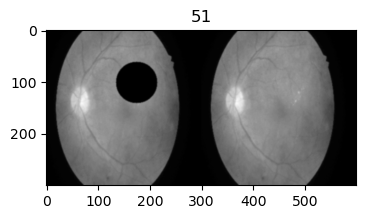

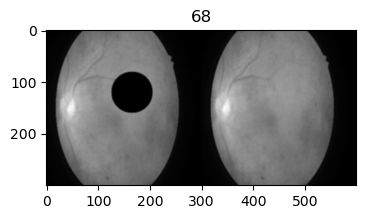

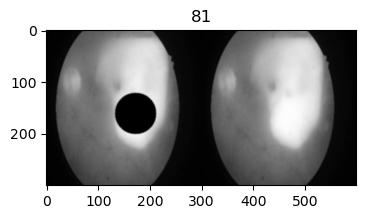

In [28]:
for x in incorr_localized:
    plt.figure(figsize=(4,4))
    plt.title(x[0])
    plt.imshow(x[1], cmap = 'gray', interpolation = 'bicubic')
    plt.show()

In [29]:
p = len(corr_localized)
n = len(incorr_localized)
acc = (p/(p+n)) * 100
print("Accuracy :",acc)

Accuracy : 96.29629629629629
